In [1]:
import cv2 
import os
import numpy as np
import matplotlib.pyplot as plt
from load_cifar_10 import unpickle, load_cifar_10_data
from sklearn.cluster import  MiniBatchKMeans, KMeans
from sklearn import svm
from sklearn.metrics import accuracy_score
batch_size=1000
cv2.__version__

'3.4.2'

Train data:  (50000, 32, 32, 3)
Train filenames:  (50000,)
Train labels:  (50000,)
Test data:  (10000, 32, 32, 3)
Test filenames:  (10000,)
Test labels:  (10000,)
Label names:  (10,)


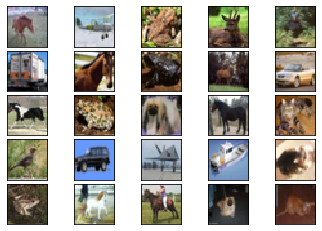

In [2]:
cifar_10_dir = 'cifar-10-batches-py'

train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
    load_cifar_10_data(cifar_10_dir)

print("Train data: ", train_data.shape)
print("Train filenames: ", train_filenames.shape)
print("Train labels: ", train_labels.shape)
print("Test data: ", test_data.shape)
print("Test filenames: ", test_filenames.shape)
print("Test labels: ", test_labels.shape)
print("Label names: ", label_names.shape)

# Don't forget that the label_names and filesnames are in binary and need conversion if used.

# display some random training images in a 25x25 grid
num_plot = 5
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
        idx = np.random.randint(0, train_data.shape[0])
        ax[m, n].imshow(train_data[idx])
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()

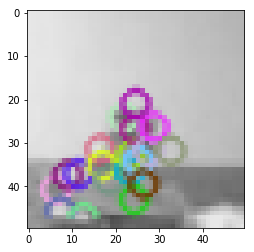

In [3]:
image = cv2.resize(train_data[100], (50, 50), interpolation=cv2.INTER_AREA)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
surf = cv2.xfeatures2d.SIFT_create()
kp, des = surf.detectAndCompute(gray,None)

copy = cv2.drawKeypoints(gray,kp, outImage = None)
plt.imshow(copy[:, :, [2, 1, 0]])

In [4]:
sift_keypoints = []

for image in train_data :
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (150, 150), interpolation=cv2.INTER_AREA)
    surf = cv2.xfeatures2d.SURF_create()
    kp, descriptors = surf.detectAndCompute(image,None)
    sift_keypoints.append(descriptors)


sift_keypoints = np.concatenate(sift_keypoints, axis=0)
# kmeans = KMeans(n_clusters = 10).fit(sift_keypoints)
mbk = MiniBatchKMeans(init='k-means++', n_clusters=64,max_iter=1000, batch_size=batch_size,
                  n_init=10, max_no_improvement=10, verbose=0).fit(sift_keypoints)
label=mbk.labels_
centroid=mbk.cluster_centers_

In [5]:
def calculate_histogram(images, model):

    feature_vectors=[]

    for image in images :

        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (150, 150), interpolation=cv2.INTER_AREA)
        #SIFT extraction
        surf = cv2.xfeatures2d.SURF_create()
        kp, descriptors = surf.detectAndCompute(image,None)
        #classification of all descriptors in the model
        predict_kmeans = model.predict(descriptors)
        #calculates the histogram
        hist, bin_edges = np.histogram(predict_kmeans, bins = 10)
        #histogram is the feature vector
        feature_vectors.append(hist)

    feature_vectors=np.asarray(feature_vectors)

    return np.array(feature_vectors)

In [6]:
x_feat_train = calculate_histogram(train_data, mbk)
x_feat_test = calculate_histogram(test_data, mbk)

In [7]:
clf = svm.LinearSVC(multi_class='ovr')
clf.fit(x_feat_train, train_labels)


y_pred = clf.predict(x_feat_test)
accuracy_score(y_pred, test_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.1902

In [8]:
def VLAD(X,visualDictionary=mbk):

    predictedLabels = visualDictionary.predict(X)
    centers = visualDictionary.cluster_centers_
    labels=visualDictionary.labels_
    k=visualDictionary.n_clusters
   
    m,d = X.shape
    V=np.zeros([k,d])
    #computing the differences

    # for all the clusters (visual words)
    for i in range(k):
        # if there is at least one descriptor in that cluster
        if np.sum(predictedLabels==i)>0:
            # add the diferences
            V[i]=np.sum(X[predictedLabels==i,:]-centers[i],axis=0)
    

    V = V.flatten()
    # power normalization, also called square-rooting normalization
    V = np.sign(V)*np.sqrt(np.abs(V))

    # L2 normalization

    V = V/np.sqrt(np.dot(V,V))
    return V

In [13]:
def getVLADDescriptors(images):
    descriptors=list()
#     idImage =list()
    surf = cv2.xfeatures2d.SURF_create()
    for im in images:
        image = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (150, 150), interpolation=cv2.INTER_AREA)
        kp,des = surf.detectAndCompute(image, None)
        if des.any():
            v=VLAD(des)
            descriptors.append(v)
#             idImage.append(imagePath)
                    
    #list to array    
    descriptors = np.asarray(descriptors)
#     return descriptors, idImage
    return descriptors

In [14]:
x_feat_train = getVLADDescriptors(train_data)
x_feat_test = getVLADDescriptors(test_data)

In [15]:
clf = svm.LinearSVC(multi_class='ovr')
clf.fit(x_feat_train, train_labels)

y_pred = clf.predict(x_feat_test)
accuracy_score(y_pred, test_labels)

0.4582